In [3]:
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from transformers import BertTokenizer, BertModel
# from transformers import AutoTokenizer, AutotModel

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [4]:
# Parameters
batch_size = 64
num_epochs = 5
num_samples = 10
learning_rate = 0.0005  # learning rate for the gradient descent optimizer, related to the step size

In [5]:
# load the "irony" dataset (name=irony)
cache_dir = "./data_cache_"
subset_name = "irony"

train_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_)} instances loaded")

val_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_)} instances loaded")

test_dataset_ = load_dataset(
    "tweet_eval",
    name=subset_name,
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_)} instances loaded")

num_classes_ = np.unique(train_dataset_['label']).size

Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

Dataset tweet_eval downloaded and prepared to ./data_cache_/tweet_eval/irony/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343. Subsequent calls will reuse this data.
Training dataset with 2862 instances loaded


Validation dataset with 955 instances loaded


Test dataset with 784 instances loaded


In [6]:
# create Tokenizer object
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# tokenizer = AutoTokenizer.from_pretrained('roberta-base')

# create 'input_ids', 'token_type_ids', 'attention_mask' for train/val/test dataset
def tokenize_function(dataset):
    model_inputs = tokenizer(dataset['text'], padding="max_length", max_length=100, truncation=True)
    return model_inputs

train_dataset_ = train_dataset_.map(tokenize_function, batched=True)
val_dataset_ = val_dataset_.map(tokenize_function, batched=True)
test_dataset_ = test_dataset_.map(tokenize_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [7]:
# convert dataset to dataloader
def convert_to_data_loader(dataset, num_classes):
    # convert from list to tensor
    input_tensor = torch.from_numpy(np.array(dataset['input_ids']))
    label_tensor = torch.from_numpy(np.array(dataset['label'])).long()
    # 'attention_mask' is also taken into consideration when constructing DataLoader(def forward())
    atten_tensor = torch.from_numpy(np.array(dataset['attention_mask']))
    
    tensor_dataset = TensorDataset(input_tensor, atten_tensor, label_tensor)
    loader = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

    return loader

# get all sentences ready for the model
train_loader = convert_to_data_loader(train_dataset_, num_classes_)
val_loader = convert_to_data_loader(val_dataset_, num_classes_)
test_loader = convert_to_data_loader(test_dataset_, num_classes_)

Build the model

In [10]:
class BertClassifier(nn.Module):
    def __init__(self, freeze_bert, aleatoric_use, num_labels):
        super(BertClassifier, self).__init__()

        # use the pretrained bert model corresponding to the previous tokenizer
        self.aleatoric_use = aleatoric_use
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        # self.bert = BertModel.from_pretrained("roberta-base")
        self.config = self.bert.config

        # specify the parameter for the classifier
        n_input = self.config.hidden_size
        n_hidden = 50
        p_ = 0.2

        # add dense layers to act as the classifier
        self.classifier = nn.Linear(n_input, n_hidden)

        self.predict = torch.nn.Linear(n_hidden, num_labels)   # predicted output
        self.get_var = torch.nn.Linear(n_hidden, num_labels)   # predicted variance

        # execute when freeze_bert=True
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        else:
            for param in self.bert.parameters():
                param.requires_grad = True
    
    def forward(self, input_ids, attention_mask):
        # get the outputs of the roberta model
        bert_outputs = self.bert(input_ids=input_ids,attention_mask=attention_mask)

        # extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_outputs = bert_outputs[0][:,0,:]

        # Feed input to classifier to compute results(one number for each class)
        x = last_hidden_state_outputs  # 64*768
        x = self.classifier(x)  # 64*50
        x = F.relu(x)  # 64*50
        x = F.dropout(x, p=0.2)  # 64*50
        
        logits = self.predict(x)  # logits layer 64*2
        if self.aleatoric_use:  # consider aleatoric uncertainty --> two sets of output
          sigma = self.get_var(x)  # uncertainty layer 64*2
          return logits, sigma
        else:
          return logits

In [11]:
# model epistemic uncertainty
model_alea = BertClassifier(freeze_bert=True, aleatoric_use=True, num_labels=num_classes_)
model_alea

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
# import torch
# predict = torch.tensor([[1,2],[2,5],[11,10],[15,12]])
# true = torch.tensor([0,1,1,0])
# label = [0,1]
# label = torch.tensor(label)


# label_pro = [[0]*num_classes_ for _ in range(true.size(0))]
# for num, i in enumerate(true.data.numpy()):
#   label_pro[num][i] = 1
# print(label_pro)

In [12]:
def aleatoric_loss_function(labels, x_i):
  golden_labels = labels.view(-1,1)
  y_hat = torch.zeros(labels.size(0), num_classes_)  # 64*2
  y_hat = y_hat.scatter(1, golden_labels, 1) # take golden_labels as index to fit "1" into y_hat

  # start to compute the loss
  loss0 = torch.log(torch.sum(torch.exp(x_i), dim=1))
            
  x_itc_hat = torch.sum(x_i*y_hat, dim=1)

  loss = abs(torch.sum(x_itc_hat-loss0))
  return loss

In [13]:
def train_aleatoric(num_epochs, model, train_dataloader, dev_dataloader):  

    loss_fn = aleatoric_loss_function  # create loss function object
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # create the optimizer
    
    # Store the data for plotting
    X = []
    train_losses_set = []
    train_accuracy_set = []
    dev_losses_set = []
    dev_accuracy_set = []
    train_uncertainty_set = []
    dev_uncertainty_set = []
    
    for e in range(num_epochs):
        # Track performance on the training set as we are learning...
        total_correct = 0
        total_trained = 0
        train_losses = []
        train_alea_uncertainty = []

        model.train()  # Put the model in training mode.

        # batch_atten(atten_mask) is also used to compute the model output
        for i, (batch_input_ids, batch_atten, batch_labels) in enumerate(train_dataloader):

            optimizer.zero_grad()  # Reset the optimizer

            prob = torch.zeros((batch_labels.size(0), num_classes_)) # 64*2
            
            # No need to use VI, we use one model for one instance each time to catch the parameter uncertainty
            # get the logit output
            mu, sigma = model(batch_input_ids, batch_atten) # 64*2
            epsilon = torch.randn(sigma.size())
            logit = mu + sigma*epsilon
            # transform the logit into probability
            prob = F.softmax(logit, dim=1) # 64*2

            # Compute the loss for the current batch of data 
            batch_loss = loss_fn(batch_labels, logit)
            # this may be meaningless during training because the weights has not been tuned properly 
            # but it can show the aleatoric uncertainty during validation and testing
            batch_alea_uncertainty = torch.sum(torch.mean(sigma, dim=1))  # the uncertainty is represented by the sum/avg of all uncertainty in the batch
            batch_alea_uncertainty = abs(batch_alea_uncertainty)
            print("my batch_loss:{}".format(batch_loss))
            print("batch_alea_uncertainty:{}".format(batch_alea_uncertainty))

            # Perform back propagation to compute the gradients with respect to each weight
            batch_loss.backward()

            # Update the weights using the compute gradients
            optimizer.step()

            # Record the loss from this sample to keep track of progress.
            train_losses.append(batch_loss.item())
            train_alea_uncertainty.append(batch_alea_uncertainty.item())

            # Count correct labels so we can compute accuracy on the training set
            pred_y = torch.max(prob, 1)[1].data.numpy() # 64*1
            total_correct += (pred_y == batch_labels.data.numpy()).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct/total_trained*100

        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Training Loss: {:.4f}".format(np.mean(train_losses)),
              "Training Uncertainty: {:.4f}".format(np.mean(train_alea_uncertainty)),
              "Training Accuracy: {:.4f}%".format(train_accuracy))
        
        X.append(e+1)
        train_losses_set.append(np.mean(train_losses))
        train_accuracy_set.append(train_accuracy)
        train_uncertainty_set.append(np.mean(train_alea_uncertainty))  # save but not using

        model.eval()  # Switch model to evaluation mode
        
        total_correct = 0
        total_trained = 0
        dev_losses = []
        dev_alea_uncertainties = []

        for dev_input_ids, dev_atten, dev_labels in dev_dataloader:
            
            dev_prob = torch.zeros((dev_labels.size(0), num_classes_)) 

            dev_mu, dev_sigma = model(dev_input_ids,dev_atten)
            epsilon = torch.randn(dev_sigma.size())
            dev_logit = dev_mu + dev_sigma*epsilon

            dev_prob = F.softmax(dev_logit, dim=1)

            # Compute the loss for the development data
            dev_loss = loss_fn(dev_labels, dev_logit)  # dev_loss computed by cross entropy
            dev_alea_uncertainty = torch.sum(torch.mean(dev_sigma, dim=1))  
            dev_alea_uncertainty = abs(dev_alea_uncertainty)

            # Save the loss on the dev set
            dev_losses.append(dev_loss.item())
            dev_alea_uncertainties.append(dev_alea_uncertainty.item())

            # Count the number of correct predictions
            dev_output_y = torch.max(dev_prob, 1)[1].data.numpy()
            total_correct += (dev_output_y == dev_labels.data.numpy()).sum().item()
            total_trained += dev_labels.size(0)
            
        dev_accuracy = total_correct/total_trained*100
        
        print("Epoch: {}/{}".format((e+1), num_epochs),
              "Validation Loss: {:.4f}".format(np.mean(dev_losses)),
              "Validation Uncertainty: {:.4f}".format(np.mean(dev_alea_uncertainties)),
              "Validation Accuracy: {:.4f}%".format(dev_accuracy))
        
        dev_losses_set.append(np.mean(dev_losses))
        dev_accuracy_set.append(dev_accuracy)
        dev_uncertainty_set.append(np.mean(dev_alea_uncertainties))  # 同样，写了但还没用
    
    # Plotting to show the accuracy and loss
    plt.figure()
    plt.plot(X,train_accuracy_set,'ob--',label='Train Accuracy')
    plt.plot(X,dev_accuracy_set,'or--',label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy(%)')
    
    plt.figure()
    plt.plot(X,train_losses_set,'ob--',label='Train Loss')
    plt.plot(X,dev_losses_set,'or--',label='Validation Loss')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Loss')

    # 试着用一下uncertainty
    plt.figure()
    plt.plot(X,train_uncertainty_set,'ob--',label='Train Uncertainty')
    plt.plot(X,dev_uncertainty_set,'or--',label='Validation Uncertainty')
    plt.legend()
    plt.xlabel('Number of epochs')
    plt.ylabel('Aleatoric Uncertainty')
    
    return model

train and validate

my batch_loss:45.78800964355469
batch_alea_uncertainty:4.230828285217285
my batch_loss:45.36634826660156
batch_alea_uncertainty:0.3144228458404541
my batch_loss:42.50104904174805
batch_alea_uncertainty:2.7969727516174316
my batch_loss:46.23796844482422
batch_alea_uncertainty:5.204643249511719
my batch_loss:45.13010025024414
batch_alea_uncertainty:7.376605987548828
my batch_loss:44.68199157714844
batch_alea_uncertainty:8.36288833618164
my batch_loss:44.46446990966797
batch_alea_uncertainty:9.129546165466309
my batch_loss:45.101436614990234
batch_alea_uncertainty:9.260181427001953
my batch_loss:45.13591766357422
batch_alea_uncertainty:9.925312042236328
my batch_loss:45.39961624145508
batch_alea_uncertainty:9.41121768951416
my batch_loss:44.484397888183594
batch_alea_uncertainty:9.194967269897461
my batch_loss:45.0647087097168
batch_alea_uncertainty:7.322320461273193
my batch_loss:45.33848571777344
batch_alea_uncertainty:6.256662845611572
my batch_loss:45.0394287109375
batch_alea_uncertai

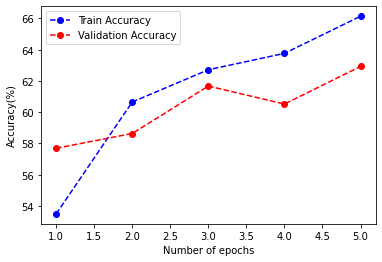

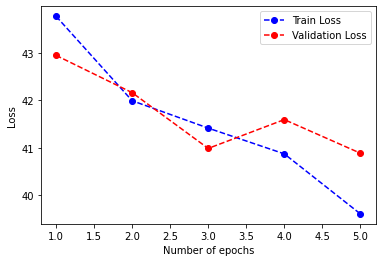

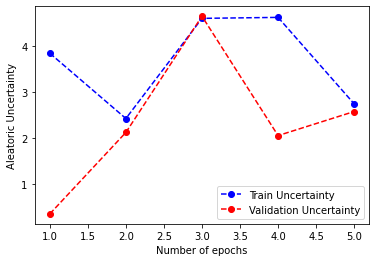

In [14]:
# model aleatoric uncertainty
trained_model = train_aleatoric(num_epochs=num_epochs, model=model_alea, train_dataloader=train_loader, dev_dataloader=val_loader)

predict

In [15]:
def predict_nn(trained_model, test_loader):

    trained_model.eval()

    correct = 0  # count the number of correct classification labels

    gold_labs = []  # gold labels to return
    pred_labs = []  # predicted labels to return
    
    for inputs, atten, labels in test_loader:
        test_mu, test_sigma = trained_model(inputs, atten)
        # take the label with biggest output as the predicted label
        predicted_labels = test_mu.argmax(1)

        gold_labs.extend(labels.tolist())
        pred_labs.extend(predicted_labels.tolist())
    
    return gold_labs, pred_labs

In [16]:
gold_labs, pred_labs = predict_nn(trained_model, test_loader)

# classification report
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
target_names = ['irony', 'not irony']
print("The classification report is:")
print(classification_report(gold_labs, pred_labs,target_names=target_names))

# confusion matrix
cm = confusion_matrix(gold_labs, pred_labs)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
print("The confusion matrix is:")
print(df_cm)

The classification report is:
              precision    recall  f1-score   support

       irony       0.74      0.59      0.66       473
   not irony       0.53      0.69      0.60       311

    accuracy                           0.63       784
   macro avg       0.64      0.64      0.63       784
weighted avg       0.66      0.63      0.64       784

The confusion matrix is:
           irony  not irony
irony        281        192
not irony     97        214


In [17]:
from sklearn.metrics import f1_score
f1_score(gold_labs, pred_labs, average='macro')

0.6286655948289567

In [18]:
from sklearn.metrics import accuracy_score
accuracy_score(gold_labs, pred_labs)

0.6313775510204082